# Reading in data...

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
ls /gdrive/MyDrive/AML/AML_group13/Data/

 2A_images/          saved_model/                  train_COVIDx_CT-2A.txt
 2A_images_sample/  'test_COVIDx_CT-2A (1).txt'   'val_COVIDx_CT-2A (1).txt'
'metadata (1).csv'   test_COVIDx_CT-2A.txt         val_COVIDx_CT-2A.txt
 metadata.csv       'train_COVIDx_CT-2A (1).txt'


In [ ]:
# !mkdir -p /gdrive/MyDrive/AML/AML_group13/Data/saved_model 

Use ImageDataGenerator to flow our images

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import PrecisionAtRecall, Recall
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import itertools 
from keras import models
from keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Flatten, Dense 
from tensorflow.keras import Sequential

In [4]:
def other_adjustment(img):
    """
    input: images 
    output: images after adjustment
    """

    # saturation and hue were deleted since our data are in grayscale (1 channel)
    
    # random brightness
    temp_image = tf.image.random_brightness(img,
                                            64.0/255,
                                            seed=None)
    
    # random contrast
    temp_image = tf.image.random_contrast(temp_image,
                                          0,
                                          0.75,
                                          seed=None)
  
    return temp_image

In [5]:
# Data augmentation
train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True,
                                   rescale=1./255,
                                   width_shift_range=(-8, 8),
                                   height_shift_range=(-8, 8),
                                   rotation_range = 90,
                                   preprocessing_function=other_adjustment) 

test_datagen = ImageDataGenerator(rescale=1./255)


Get dataset from sampled folder by `datagen.flow_from_directory` (9000 training, 1800 validation, 1800 testing), create two training generator, augmented and non-augmented, we will compare how augmentation affect model training in next section. 

In [6]:
root_path = "/gdrive/MyDrive/AML/AML_group13/Data"
train_path = root_path + "/2A_images_sample/train"
val_path = root_path + "/2A_images_sample/val"
test_path = root_path + "/2A_images_sample/test"
target_size = (128, 128)
batch_size = 64


train_generator = train_datagen.flow_from_directory(
    train_path, 
    color_mode = "rgb",
    target_size=target_size,
    batch_size=batch_size
)

val_generator = test_datagen.flow_from_directory(
    val_path, 
    color_mode = "rgb",
    target_size=target_size,
    batch_size=batch_size    
)

test_generator = test_datagen.flow_from_directory(
    test_path, 
    color_mode = "rgb",
    target_size=target_size,
    batch_size=batch_size,
    shuffle = False    
)

train_generator_unaug = test_datagen.flow_from_directory(
    train_path, 
    color_mode = "rgb",
    target_size=target_size,
    batch_size=batch_size
)


Found 9000 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.
Found 9000 images belonging to 3 classes.


# Build Model

We are using Convolutional Neural Network (CNN) to classify images. 

### Hyperparameter Tuning

DO NOT need to re-run the code below to get optimized structure. The outputted structure is the optimized one.



In [ ]:
! pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 4.1 MB/s 


In [ ]:
import keras_tuner as kt
from tensorflow import keras

In [ ]:
def model_builder(hp):
  mymodel = models.Sequential()
  mymodel.add(layers.Conv2D(32, (3, 3), activation='relu', 
                          input_shape=(IMG_SIZE, IMG_SIZE, 3)))
  mymodel.add(layers.MaxPooling2D())
  mymodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
  mymodel.add(layers.MaxPooling2D())
  mymodel.add(layers.Conv2D(128, (3, 3), activation='relu'))
  mymodel.add(layers.MaxPooling2D())
  mymodel.add(layers.Flatten())

  hp_units = hp.Int('units', min_value=32, max_value=96, step=32)
  mymodel.add(keras.layers.Dense(units=hp_units, activation='relu'))

  hp_units2 = hp.Int('units2', min_value=32, max_value=64, step=32)
  mymodel.add(keras.layers.Dense(units=hp_units2, activation='relu'))

  mymodel.add(keras.layers.Dense(3, activation='softmax'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

  mymodel.compile(optimizer = Adam(learning_rate=hp_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False),
                loss='categorical_crossentropy',
                metrics=['accuracy',Recall()])

  return mymodel


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir2',
                     project_name='covidxray')

INFO:tensorflow:Reloading Oracle from existing project my_dir2/covidxray/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir2/covidxray/tuner0.json


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
tuner.search(train_generator, validation_data= val_generator, epochs=20, callbacks=[stop_early])

INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}.
The optimal number of units in the second densely-connected
layer is {best_hps.get('units2')}.
The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 96.
The optimal number of units in the second densely-connected
layer is 64.
The optimal learning rate for the optimizer
is 0.001.



### Tuner for un_augmented training set.

In [ ]:
tuner_unaug = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir2_unaug',
                     project_name='covidxray')

INFO:tensorflow:Reloading Oracle from existing project my_dir2_unaug/covidxray/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir2_unaug/covidxray/tuner0.json


In [ ]:
tuner_unaug.search(train_generator_unaug, validation_data= val_generator, epochs=20, callbacks=[stop_early])


Trial 19 Complete [00h 01m 36s]
val_accuracy: 0.7816666960716248

Best val_accuracy So Far: 0.7816666960716248
Total elapsed time: 00h 04m 55s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner_unaug.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}.
The optimal number of units in the second densely-connected
layer is {best_hps.get('units2')}.
The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 32.
The optimal number of units in the second densely-connected
layer is 64.
The optimal learning rate for the optimizer
is 0.01.



### Model training

In [ ]:
# define helper function

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  #plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


#### With augmentation

In [ ]:
# mymodel is the model trained with tuned structure. load the model with path /gdrive/MyDrive/AML/AML_group13/Data/saved_model/my_model1_aug

IMG_SIZE = 128
mymodel = models.Sequential()
mymodel.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
mymodel.add(layers.MaxPooling2D())
mymodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
mymodel.add(layers.MaxPooling2D())
mymodel.add(layers.Conv2D(128, (3, 3), activation='relu'))
mymodel.add(layers.MaxPooling2D())
mymodel.add(layers.Flatten())
mymodel.add(layers.Dense(96, activation='relu'))
mymodel.add(layers.Dense(64, activation='relu'))
mymodel.add(layers.Dense(3, activation='softmax'))


In [ ]:
mymodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 128)     

In [ ]:
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

mymodel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',Recall()])

In [ ]:
# Do not need to re-run this, directly load model
#mymodel_history = mymodel.fit(train_generator, validation_data=val_generator, epochs=30)

Epoch 1/30
141/141 [==============================] - 56s 394ms/step - loss: 1.0770 - accuracy: 0.3953 - recall_3: 0.0387 - val_loss: 2.0658 - val_accuracy: 0.4989 - val_recall_3: 0.4956
Epoch 2/30
141/141 [==============================] - 55s 392ms/step - loss: 0.9961 - accuracy: 0.4907 - recall_3: 0.1923 - val_loss: 1.0104 - val_accuracy: 0.5750 - val_recall_3: 0.5389
Epoch 3/30
141/141 [==============================] - 55s 390ms/step - loss: 0.9414 - accuracy: 0.5463 - recall_3: 0.3256 - val_loss: 1.4355 - val_accuracy: 0.4200 - val_recall_3: 0.3917
Epoch 4/30
141/141 [==============================] - 55s 389ms/step - loss: 0.9078 - accuracy: 0.5707 - recall_3: 0.3856 - val_loss: 1.0853 - val_accuracy: 0.6022 - val_recall_3: 0.5956
Epoch 5/30
141/141 [==============================] - 55s 391ms/step - loss: 0.8703 - accuracy: 0.5878 - recall_3: 0.4417 - val_loss: 1.7701 - val_accuracy: 0.5294 - val_recall_3: 0.5261
Epoch 6/30
141/141 [==============================] - 55s 388ms/s

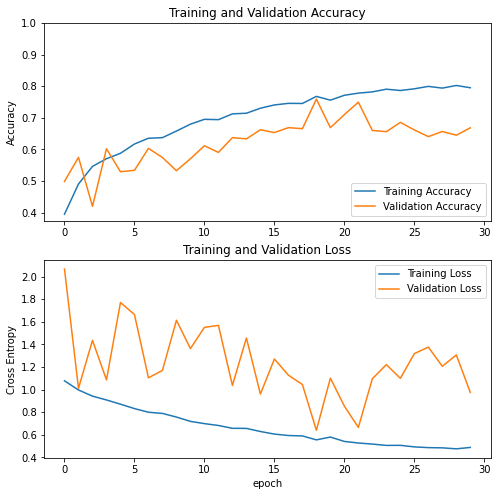

In [ ]:
plot_history(mymodel_history)

In [ ]:
mymodel =  tf.keras.models.load_model('/gdrive/MyDrive/AML/AML_group13/Data/saved_model/my_model1_aug')

#### without augmentation

In [ ]:
# Do not need to run this, directly load the model in the next block
IMG_SIZE = 128
mymodel2_unaug = models.Sequential()
mymodel2_unaug.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
mymodel2_unaug.add(layers.MaxPooling2D())
mymodel2_unaug.add(layers.Conv2D(64, (3, 3), activation='relu'))
mymodel2_unaug.add(layers.MaxPooling2D())
mymodel2_unaug.add(layers.Conv2D(128, (3, 3), activation='relu'))
mymodel2_unaug.add(layers.MaxPooling2D())
mymodel2_unaug.add(layers.Flatten())
mymodel2_unaug.add(layers.Dense(32, activation='relu'))
mymodel2_unaug.add(layers.Dense(64, activation='relu'))
mymodel2_unaug.add(layers.Dense(3, activation='softmax'))

opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)


mymodel2_unaug.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy',Recall()])

mymodel2_unaug_history = mymodel2_unaug.fit(train_generator_unaug, validation_data=val_generator, epochs=30)

Epoch 1/30
141/141 [==============================] - 4081s 29s/step - loss: 1.0072 - accuracy: 0.6168 - recall: 0.4534 - val_loss: 0.6964 - val_accuracy: 0.7050 - val_recall: 0.6761
Epoch 2/30
141/141 [==============================] - 19s 135ms/step - loss: 0.4437 - accuracy: 0.8309 - recall: 0.8114 - val_loss: 0.5625 - val_accuracy: 0.7606 - val_recall: 0.7511
Epoch 3/30
141/141 [==============================] - 19s 138ms/step - loss: 0.3564 - accuracy: 0.8707 - recall: 0.8590 - val_loss: 0.5160 - val_accuracy: 0.7761 - val_recall: 0.7689
Epoch 4/30
141/141 [==============================] - 19s 135ms/step - loss: 0.3183 - accuracy: 0.8810 - recall: 0.8731 - val_loss: 0.4780 - val_accuracy: 0.7961 - val_recall: 0.7817
Epoch 5/30
141/141 [==============================] - 19s 137ms/step - loss: 0.2930 - accuracy: 0.8952 - recall: 0.8873 - val_loss: 0.5133 - val_accuracy: 0.7828 - val_recall: 0.7706
Epoch 6/30
141/141 [==============================] - 19s 135ms/step - loss: 0.2739 -

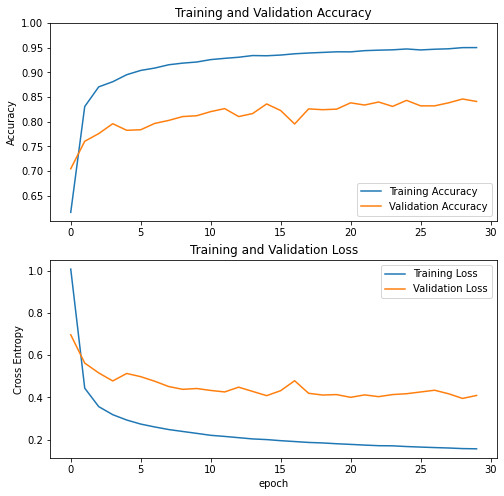

In [ ]:
plot_history(mymodel2_unaug_history)                                

In [ ]:
mymodel2_unaug =  tf.keras.models.load_model('/gdrive/MyDrive/AML/AML_group13/Data/saved_model/mymodel2_aug_tuned')

In [ ]:
# save model for reuse, only need to save once

# mymodel.save('/gdrive/MyDrive/AML/AML_group13/Data/saved_model/my_model1_aug_tuned')
mymodel2_unaug.save('/gdrive/MyDrive/AML/AML_group13/Data/saved_model/mymodel2_aug_tuned')

INFO:tensorflow:Assets written to: /gdrive/MyDrive/AML/AML_group13/Data/saved_model/mymodel2_aug_tuned/assets


### Evaluation on test set

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
classes = ['COVID-19', 'Normal', 'Penumonia']
Y_pred = mymodel.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

Y_pred_unaug = mymodel2_unaug.predict(test_generator)
y_pred_unaug = np.argmax(Y_pred_unaug, axis=1)

In [ ]:
mymodel.evaluate(test_generator)

29/29 [==============================] - 3s 93ms/step - loss: 0.6560 - accuracy: 0.7933 - recall_7: 0.7883


[0.6559690237045288, 0.7933333516120911, 0.7883333563804626]

In [ ]:
mymodel2_unaug.evaluate(test_generator)

29/29 [==============================] - 3s 92ms/step - loss: 0.4447 - accuracy: 0.8400 - recall: 0.8350


[0.44468173384666443, 0.8399999737739563, 0.8349999785423279]

#### Confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix with augmentation...
Normalized confusion matrix
Confusion matrix, without normalization


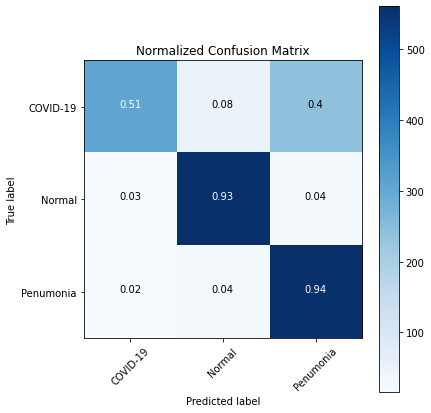

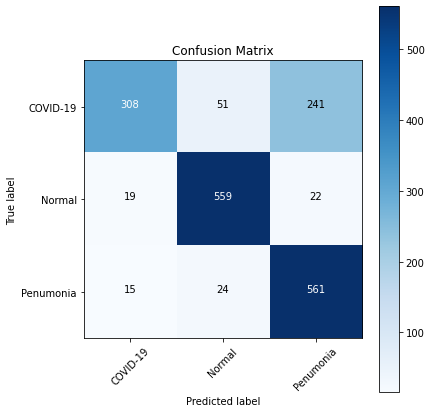

In [ ]:
print('Confusion Matrix with augmentation...')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, classes, title='Normalized Confusion Matrix')
plot_confusion_matrix(cm, classes,False, title='Confusion Matrix')

Confusion Matrix with NO augmentation...
Normalized confusion matrix
Confusion matrix, without normalization


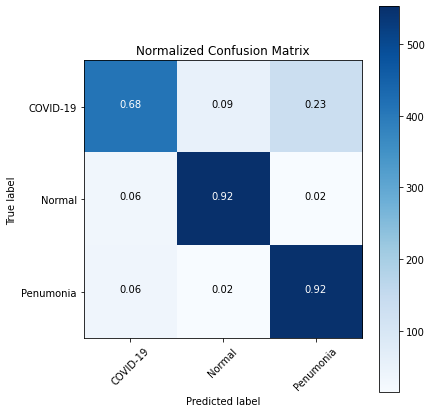

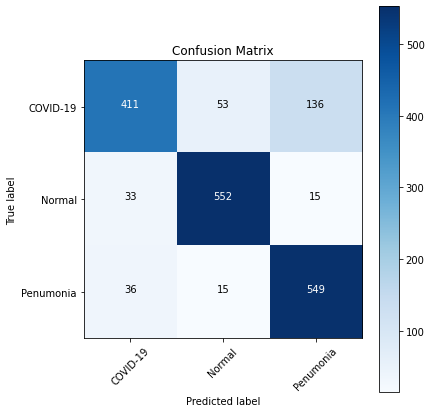

In [ ]:
print('Confusion Matrix with NO augmentation...')
cm = confusion_matrix(test_generator.classes, y_pred_unaug)
plot_confusion_matrix(cm, classes, title='Normalized Confusion Matrix')
plot_confusion_matrix(cm, classes,False, title='Confusion Matrix')

#### Evaluation metrics by class

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
def generate_evaluation(y_true, predictions):
  acc = accuracy_score(y_true, predictions)
  results_all = precision_recall_fscore_support(y_true, predictions, average='macro', zero_division=1)
  results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division=1)

  metric_columns =  ['Precision','Recall', 'F-Score','S']
  all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
  all_df.columns = metric_columns
  all_df.index = classes + ['Total']

  def metrics_plot(df,metric):
      plt.figure(figsize=(10,5))
      ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
      #Bar Labels
      for p in ax.patches:
          ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
          ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
          
      sns.despine(top=True, right=True, left=True, bottom=False)
      ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
      ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
      ax.set(yticklabels=[])
      ax.axes.get_yaxis().set_visible(False) 
      plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
  metrics_plot(all_df, 'Precision')#Results by Class
  metrics_plot(all_df, 'Recall')#Results by Class
  metrics_plot(all_df, 'F-Score')#Results by Class
  print('**Overall Results**')
  print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
  print('Precision Result: %.2f%%'%(all_df.iloc[3,0]*100))#Precision of the whole Dataset
  print('Recall Result: %.2f%%'%(all_df.iloc[3,1]*100))#Recall of the whole Dataset
  print('F-Score Result: %.2f%%'%(all_df.iloc[3,2]*100))#F-Score of the whole Dataset


with augmentation...
**Overall Results**
Accuracy Result: 79.33%
Precision Result: 82.10%
Recall Result: 79.33%
F-Score Result: 78.26%


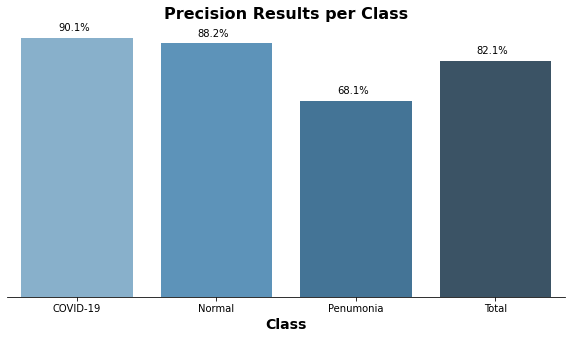

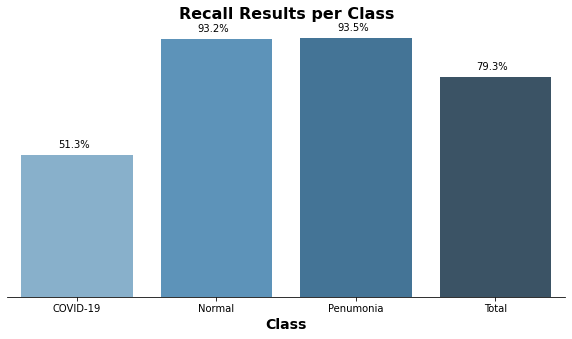

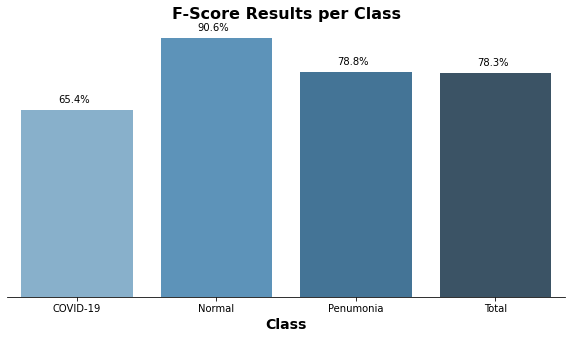

In [ ]:
print('with augmentation...')
generate_evaluation(test_generator.classes, y_pred)

with NO augmentation...
**Overall Results**
Accuracy Result: 84.00%
Precision Result: 84.36%
Recall Result: 84.00%
F-Score Result: 83.69%


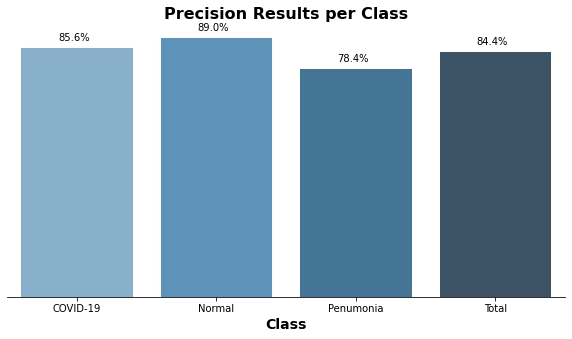

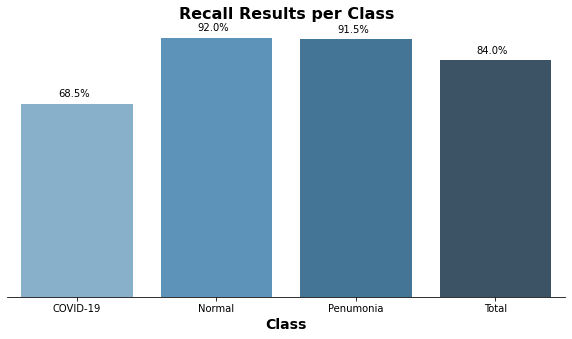

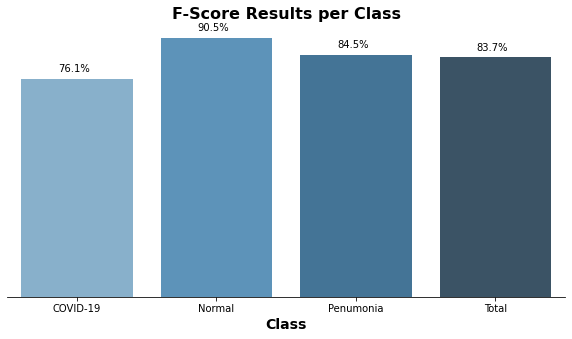

In [ ]:
print('with NO augmentation...')
Y_pred2 = mymodel2_unaug.predict(test_generator)
y_pred2 = np.argmax(Y_pred2, axis=1)
generate_evaluation(test_generator.classes, y_pred_unaug)

## Transfer Learning

### VGG16

The first approach we made is using VGG16, one of the winning model in ILSVRC competitions. We will create a model based from keras VGG16 which was pre-trained on ImageNet dataset. 

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
input_shape = (128, 128, 3)
output_shape = 3

# use pretrained vgg16 model
vgg16_model = VGG16(include_top=False, input_shape=input_shape)
vgg16_model.trainable=False
vgg16_model.summary()


58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
average_layer = GlobalAveragePooling2D()
flatten_layer = Flatten()
dense_layer = Dense(64, activation="relu")
output_layer = Dense(output_shape, activation="softmax")
model1 = Sequential([vgg16_model, 
                     average_layer, 
                     dense_layer,
                     output_layer])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 14,747,715
Trainable params: 33,027
Non-trainable params: 14,714,688
_________________________________________________________________


#### Compare Model Performence With/Without Data Augmentation

We will train the same model (with same initial weight) on augmented training set and non-augmented training set. 

In [ ]:
initial_weights = model1.get_weights()

Compile the model using categorical cross-entropy, and create early stopping to prevent overfitting. 

In [ ]:
epochs = 30

model1.compile(optimizer=Adam(0.01),
               loss="categorical_crossentropy",
               metrics=["accuracy", Recall()])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)

Train with augmented training set.

In [ ]:
model1.set_weights(initial_weights)

vgg16_history = model1.fit(
    train_generator, 
    epochs=epochs,
    callbacks=[callback],
    validation_data=val_generator
)

Epoch 1/30
141/141 [==============================] - 112s 797ms/step - loss: 0.8835 - accuracy: 0.5667 - recall: 0.3843 - val_loss: 0.9772 - val_accuracy: 0.5711 - val_recall: 0.5233
Epoch 2/30
141/141 [==============================] - 112s 792ms/step - loss: 0.7393 - accuracy: 0.6499 - recall: 0.5489 - val_loss: 1.0922 - val_accuracy: 0.5494 - val_recall: 0.5206
Epoch 3/30
141/141 [==============================] - 112s 791ms/step - loss: 0.6950 - accuracy: 0.6770 - recall: 0.5788 - val_loss: 0.9803 - val_accuracy: 0.5889 - val_recall: 0.5689
Epoch 4/30
141/141 [==============================] - 111s 788ms/step - loss: 0.6910 - accuracy: 0.6763 - recall: 0.5879 - val_loss: 0.9955 - val_accuracy: 0.5994 - val_recall: 0.5883
Epoch 5/30
141/141 [==============================] - 111s 790ms/step - loss: 0.6756 - accuracy: 0.6913 - recall: 0.6076 - val_loss: 0.8480 - val_accuracy: 0.6500 - val_recall: 0.6256
Epoch 6/30
141/141 [==============================] - 112s 794ms/step - loss: 0.

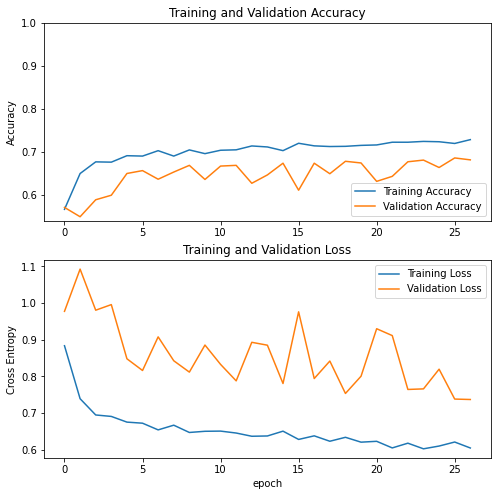

In [ ]:
plot_history(vgg16_history) 

In [ ]:
# save model for reuse, only need to save once

model1.save('/gdrive/MyDrive/AML/AML_group13/Data/saved_model/vgg16_model_aug')

INFO:tensorflow:Assets written to: /gdrive/MyDrive/AML/AML_group13/Data/saved_model/vgg16_model_aug/assets


Train with non-augmented training set.

In [ ]:
model1.set_weights(initial_weights)

vgg16_unaug_history = model1.fit(
    train_generator_unaug, 
    epochs=epochs,
    callbacks=[callback],
    validation_data=val_generator
)

Epoch 1/30
141/141 [==============================] - 35s 249ms/step - loss: 0.6231 - accuracy: 0.7431 - recall: 0.6796 - val_loss: 0.4893 - val_accuracy: 0.7800 - val_recall: 0.7650
Epoch 2/30
141/141 [==============================] - 35s 244ms/step - loss: 0.3589 - accuracy: 0.8580 - recall: 0.8473 - val_loss: 0.4307 - val_accuracy: 0.8094 - val_recall: 0.8000
Epoch 3/30
141/141 [==============================] - 35s 245ms/step - loss: 0.3063 - accuracy: 0.8823 - recall: 0.8760 - val_loss: 0.5232 - val_accuracy: 0.7861 - val_recall: 0.7756
Epoch 4/30
141/141 [==============================] - 35s 244ms/step - loss: 0.2790 - accuracy: 0.8947 - recall: 0.8888 - val_loss: 0.4064 - val_accuracy: 0.8367 - val_recall: 0.8322
Epoch 5/30
141/141 [==============================] - 35s 244ms/step - loss: 0.2692 - accuracy: 0.8957 - recall: 0.8909 - val_loss: 0.4193 - val_accuracy: 0.8361 - val_recall: 0.8306
Epoch 6/30
141/141 [==============================] - 35s 244ms/step - loss: 0.2370 -

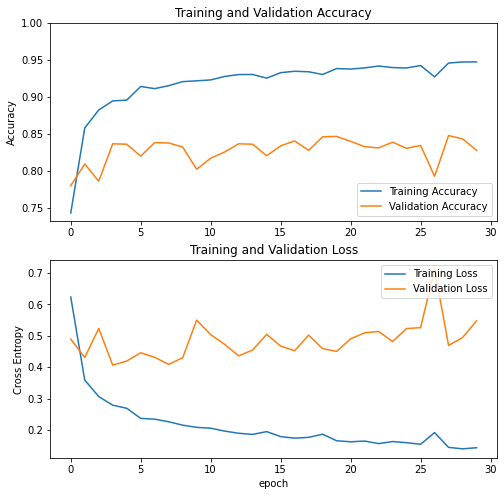

In [ ]:
plot_history(vgg16_unaug_history) 

In [ ]:
# save model for reuse, only need to save once

model1.save('/gdrive/MyDrive/AML/AML_group13/Data/saved_model/vgg16_model_unaug')

INFO:tensorflow:Assets written to: /gdrive/MyDrive/AML/AML_group13/Data/saved_model/vgg16_model_unaug/assets


### ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
input_shape = (128, 128, 3)
output_shape = 3

base_model = ResNet50(input_shape=input_shape, include_top=False)
base_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [ ]:
flatten_layer = Flatten()
average_layer = GlobalAveragePooling2D()
dense_layer = Dense(64, activation="relu")
output_layer = Dense(output_shape, activation="softmax")
model2 = Sequential([base_model, 
                     average_layer, 
                     # No need to call flatten as global average pooling already flatten the weights
                     # flatten_layer,
                     dense_layer,
                     output_layer])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 64)                131136    
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 23,719,043
Trainable params: 23,665,923
Non-trainable params: 53,120
_________________________________________________________________


#### Compare Model Performence With/Without Data Augmentation

We will train the same model (with same initial weight) on augmented training set and non-augmented training set. 

In [ ]:
initial_weights = model2.get_weights()

Compile the model using categorical cross-entropy, and create early stopping to prevent overfitting. 

In [ ]:
epochs = 30

model2.compile(optimizer=Adam(0.0001),
               loss="categorical_crossentropy",
               metrics=["accuracy", Recall()])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)

Train with augmented training set.

In [ ]:
model2.set_weights(initial_weights)

resnet50_history = model2.fit(
    train_generator, 
    epochs=epochs,
    callbacks=[callback],
    validation_data=val_generator
)

Epoch 1/30
141/141 [==============================] - 179s 1s/step - loss: 0.4719 - accuracy: 0.8023 - recall_1: 0.7711 - val_loss: 1.3897 - val_accuracy: 0.3333 - val_recall_1: 0.3333
Epoch 2/30
141/141 [==============================] - 166s 1s/step - loss: 0.2562 - accuracy: 0.9037 - recall_1: 0.8942 - val_loss: 0.9165 - val_accuracy: 0.6383 - val_recall_1: 0.5850
Epoch 3/30
141/141 [==============================] - 167s 1s/step - loss: 0.2098 - accuracy: 0.9210 - recall_1: 0.9137 - val_loss: 0.6477 - val_accuracy: 0.7333 - val_recall_1: 0.7156
Epoch 4/30
141/141 [==============================] - 166s 1s/step - loss: 0.1709 - accuracy: 0.9329 - recall_1: 0.9264 - val_loss: 0.6044 - val_accuracy: 0.7833 - val_recall_1: 0.7806
Epoch 5/30
141/141 [==============================] - 167s 1s/step - loss: 0.1583 - accuracy: 0.9401 - recall_1: 0.9339 - val_loss: 0.3329 - val_accuracy: 0.8739 - val_recall_1: 0.8678
Epoch 6/30
141/141 [==============================] - 167s 1s/step - loss: 

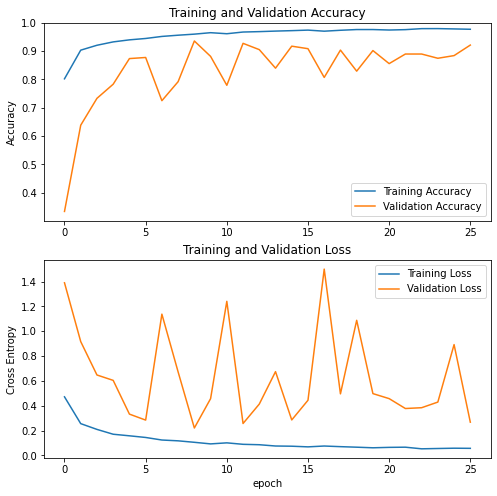

In [ ]:
plot_history(resnet50_history) 

In [ ]:
# save model for reuse, only need to save once

model2.save('/gdrive/MyDrive/AML/AML_group13/Data/saved_model/resnet50_model_aug')

INFO:tensorflow:Assets written to: /gdrive/MyDrive/AML/AML_group13/Data/saved_model/resnet50_model_aug/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Train with non-augmented training set.

In [ ]:
model2.set_weights(initial_weights)

resnet50_unaug_history = model2.fit(
    train_generator_unaug, 
    epochs=epochs,
    callbacks=[callback],
    validation_data=val_generator
)

Epoch 1/30
141/141 [==============================] - 90s 637ms/step - loss: 0.1996 - accuracy: 0.9258 - recall_1: 0.9168 - val_loss: 4.5829 - val_accuracy: 0.3333 - val_recall_1: 0.3333
Epoch 2/30
141/141 [==============================] - 90s 635ms/step - loss: 0.0402 - accuracy: 0.9857 - recall_1: 0.9852 - val_loss: 2.0932 - val_accuracy: 0.3400 - val_recall_1: 0.3289
Epoch 3/30
141/141 [==============================] - 90s 636ms/step - loss: 0.0158 - accuracy: 0.9950 - recall_1: 0.9947 - val_loss: 1.1372 - val_accuracy: 0.4644 - val_recall_1: 0.2583
Epoch 4/30
141/141 [==============================] - 90s 635ms/step - loss: 0.0067 - accuracy: 0.9979 - recall_1: 0.9978 - val_loss: 0.7690 - val_accuracy: 0.6767 - val_recall_1: 0.6161
Epoch 5/30
141/141 [==============================] - 90s 636ms/step - loss: 0.0095 - accuracy: 0.9973 - recall_1: 0.9973 - val_loss: 1.1561 - val_accuracy: 0.6422 - val_recall_1: 0.6222
Epoch 6/30
141/141 [==============================] - 90s 636ms/s

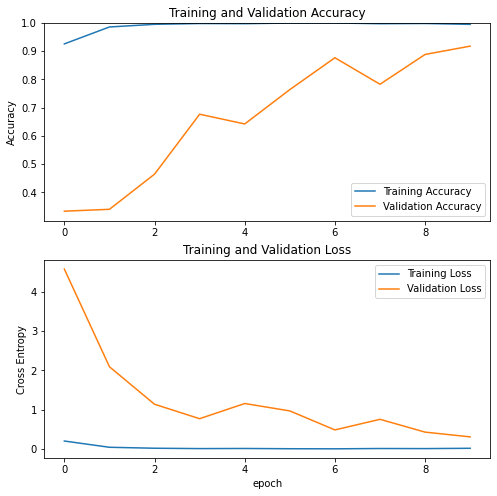

In [ ]:
plot_history(resnet50_unaug_history) 

In [ ]:
# save model for reuse, only need to save once

model2.save('/gdrive/MyDrive/AML/AML_group13/Data/saved_model/resnet50_model_unaug')

INFO:tensorflow:Assets written to: /gdrive/MyDrive/AML/AML_group13/Data/saved_model/resnet50_model_unaug/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


### Evaluation on Testing Set


In [ ]:
# load models
vgg16_model_aug =  tf.keras.models.load_model('/gdrive/MyDrive/AML/AML_group13/Data/saved_model/vgg16_model_aug')
vgg16_model_unaug =  tf.keras.models.load_model('/gdrive/MyDrive/AML/AML_group13/Data/saved_model/vgg16_model_unaug')

resnet50_model_aug =  tf.keras.models.load_model('/gdrive/MyDrive/AML/AML_group13/Data/saved_model/resnet50_model_aug')
resnet50_model_unaug =  tf.keras.models.load_model('/gdrive/MyDrive/AML/AML_group13/Data/saved_model/resnet50_model_unaug')

In [ ]:
print("Evaluate VGG16 Model with augmentation...")
vgg16_model_aug.evaluate(test_generator)
print()
print("Evaluate VGG16 Model without augmentation...")
vgg16_model_unaug.evaluate(test_generator)
print()
print("Evaluate ResNet50 Model with augmentation...")
resnet50_model_aug.evaluate(test_generator)
print()
print("Evaluate ResNet50 Model without augmentation...")
resnet50_model_unaug.evaluate(test_generator)
print()

Evaluate VGG16 Model with augmentation...
29/29 [==============================] - 521s 19s/step - loss: 0.7280 - accuracy: 0.6961 - recall: 0.6817

Evaluate VGG16 Model without augmentation...
29/29 [==============================] - 6s 198ms/step - loss: 0.5266 - accuracy: 0.8333 - recall: 0.8283

Evaluate ResNet50 Model with augmentation...
29/29 [==============================] - 7s 203ms/step - loss: 0.3197 - accuracy: 0.8894 - recall_1: 0.8872

Evaluate ResNet50 Model without augmentation...
29/29 [==============================] - 7s 203ms/step - loss: 0.3421 - accuracy: 0.9189 - recall_1: 0.9183



In [ ]:
# VGG16
y_pred_vgg16_aug = np.argmax(vgg16_model_aug.predict(test_generator), axis=1)
y_pred_vgg16_unaug = np.argmax(vgg16_model_unaug.predict(test_generator), axis=1)

# ResNet50
y_pred_resnet50_aug = np.argmax(resnet50_model_aug.predict(test_generator), axis=1)
y_pred_resnet50_unaug = np.argmax(resnet50_model_unaug.predict(test_generator), axis=1)

#### Confusion Matrix

Confusion Matrix with augmentation using VGG16...
Normalized confusion matrix
Confusion matrix, without normalization


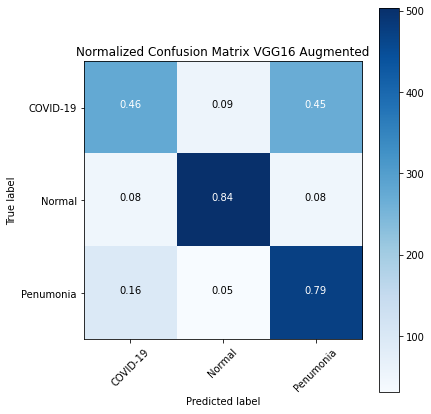

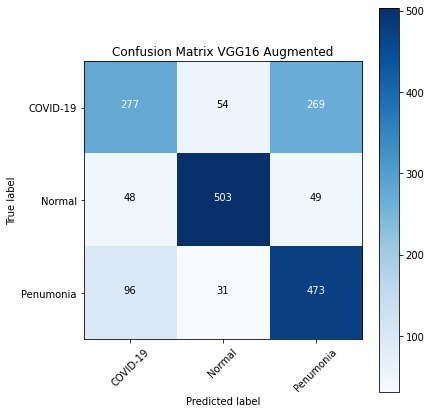

In [ ]:
print('Confusion Matrix with augmentation using VGG16...')
cm_vgg16_aug = confusion_matrix(test_generator.classes, y_pred_vgg16_aug)
plot_confusion_matrix(cm_vgg16_aug, classes, title='Normalized Confusion Matrix VGG16 Augmented')
plot_confusion_matrix(cm_vgg16_aug, classes,False, title='Confusion Matrix VGG16 Augmented')

Confusion Matrix without augmentation using VGG16...
Normalized confusion matrix
Confusion matrix, without normalization


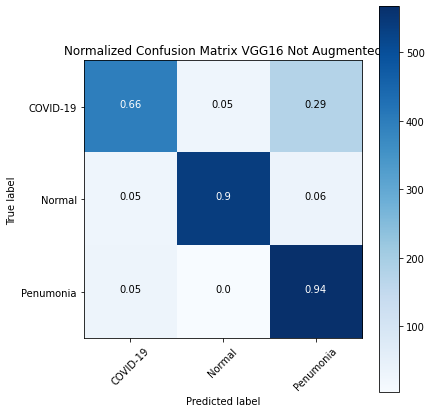

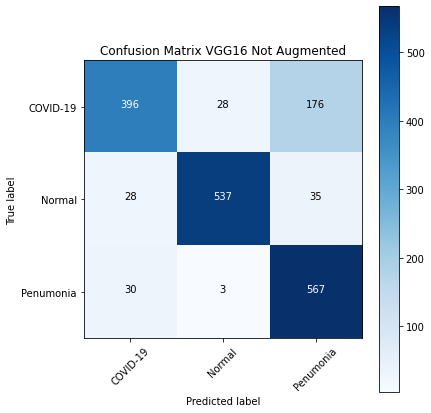

In [ ]:
print('Confusion Matrix without augmentation using VGG16...')
cm_vgg16_unaug = confusion_matrix(test_generator.classes, y_pred_vgg16_unaug)
plot_confusion_matrix(cm_vgg16_unaug, classes, title='Normalized Confusion Matrix VGG16 Not Augmented')
plot_confusion_matrix(cm_vgg16_unaug, classes,False, title='Confusion Matrix VGG16 Not Augmented')

Confusion Matrix with augmentation using ResNet50...
Normalized confusion matrix
Confusion matrix, without normalization


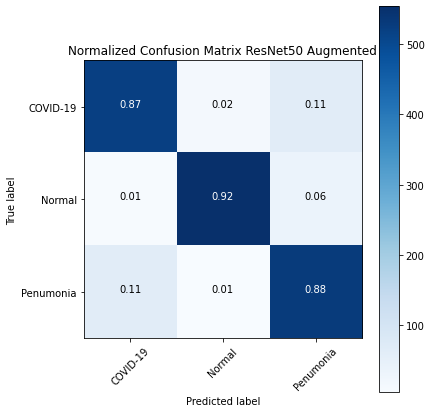

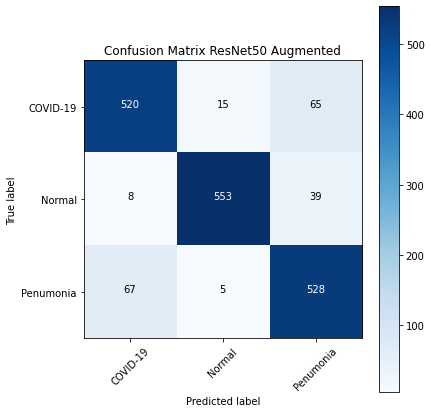

In [ ]:
print('Confusion Matrix with augmentation using ResNet50...')
cm_resnet50_aug = confusion_matrix(test_generator.classes, y_pred_resnet50_aug)
plot_confusion_matrix(cm_resnet50_aug, classes, title='Normalized Confusion Matrix ResNet50 Augmented')
plot_confusion_matrix(cm_resnet50_aug, classes,False, title='Confusion Matrix ResNet50 Augmented')

Confusion Matrix without augmentation using ResNet50...
Normalized confusion matrix
Confusion matrix, without normalization


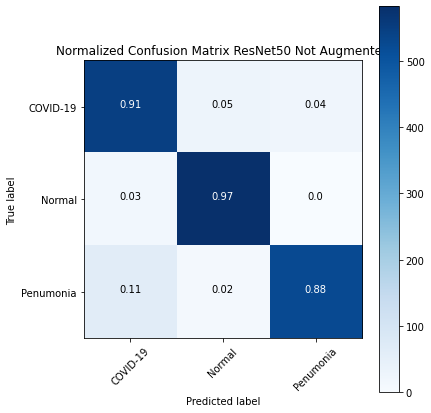

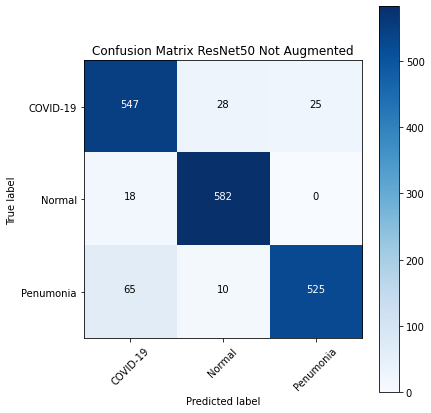

In [ ]:
print('Confusion Matrix without augmentation using ResNet50...')
cm_resnet50_unaug = confusion_matrix(test_generator.classes, y_pred_resnet50_unaug)
plot_confusion_matrix(cm_resnet50_unaug, classes, title='Normalized Confusion Matrix ResNet50 Not Augmented')
plot_confusion_matrix(cm_resnet50_unaug, classes,False, title='Confusion Matrix ResNet50 Not Augmented')

#### Evaluation Matrix by Class

VGG16 with augmentation...
**Overall Results**
Accuracy Result: 69.61%
Precision Result: 70.38%
Recall Result: 69.61%
F-Score Result: 68.98%


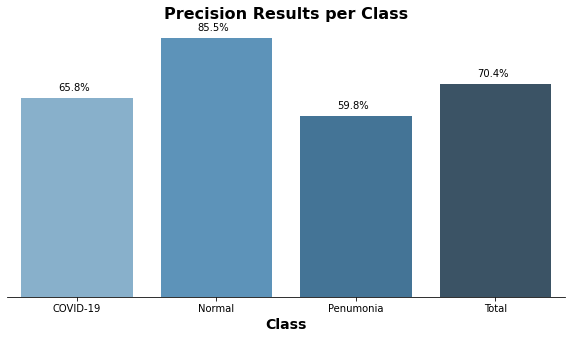

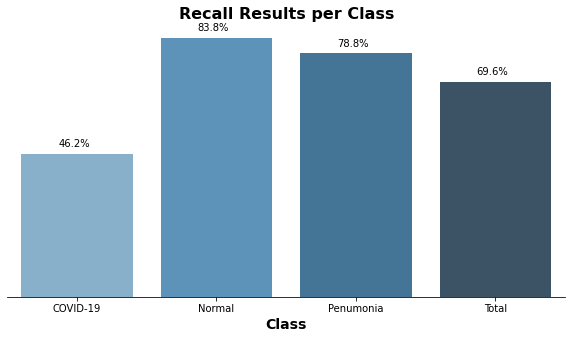

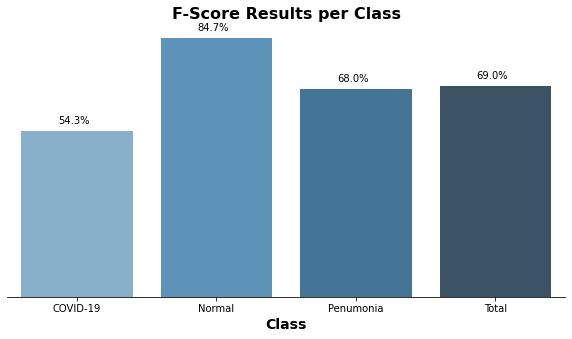

In [ ]:
print('VGG16 with augmentation...')
generate_evaluation(test_generator.classes, y_pred_vgg16_aug)

VGG16 without augmentation...
**Overall Results**
Accuracy Result: 83.33%
Precision Result: 84.88%
Recall Result: 83.33%
F-Score Result: 83.13%


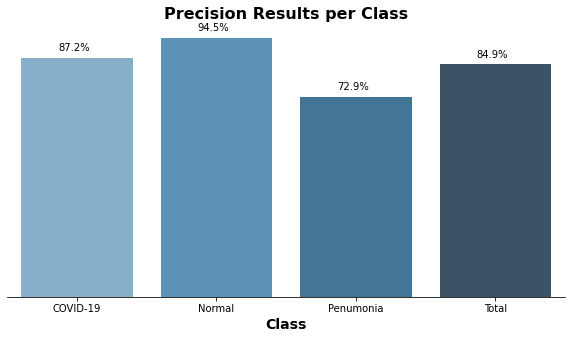

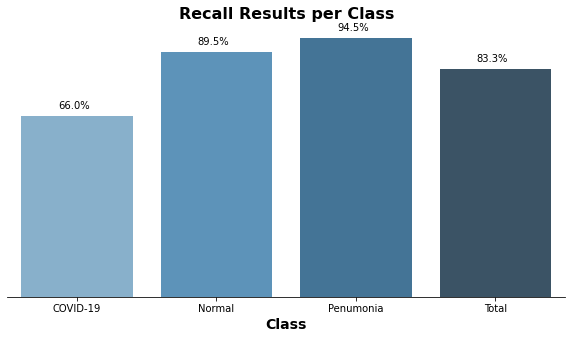

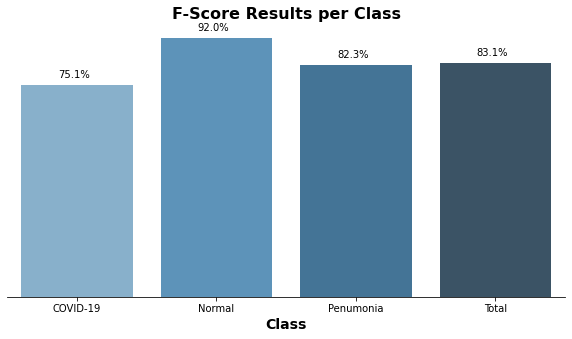

In [ ]:
print('VGG16 without augmentation...')
generate_evaluation(test_generator.classes, y_pred_vgg16_unaug)

ResNet50 with augmentation...
**Overall Results**
Accuracy Result: 88.94%
Precision Result: 89.15%
Recall Result: 88.94%
F-Score Result: 89.01%


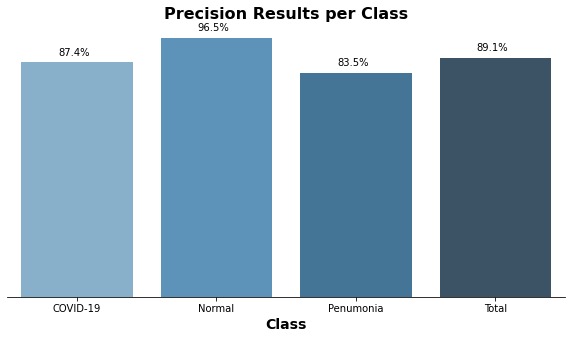

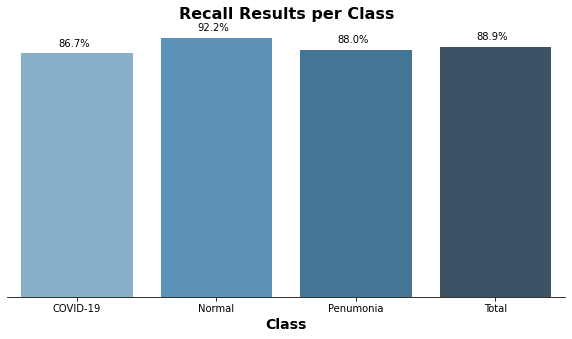

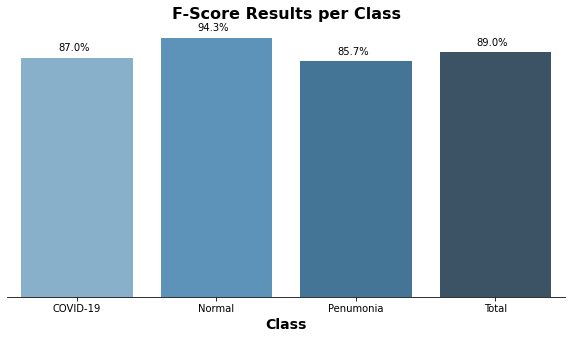

In [ ]:
print('ResNet50 with augmentation...')
generate_evaluation(test_generator.classes, y_pred_resnet50_aug)

ResNet50 without augmentation...
**Overall Results**
Accuracy Result: 91.89%
Precision Result: 92.05%
Recall Result: 91.89%
F-Score Result: 91.89%


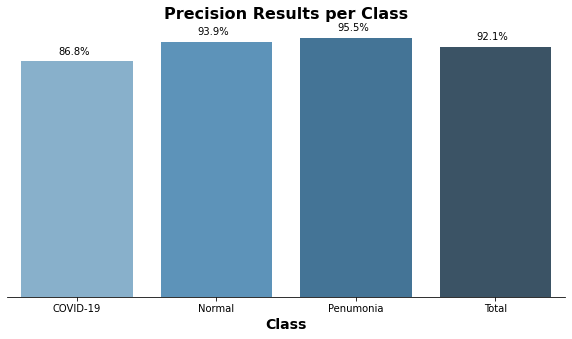

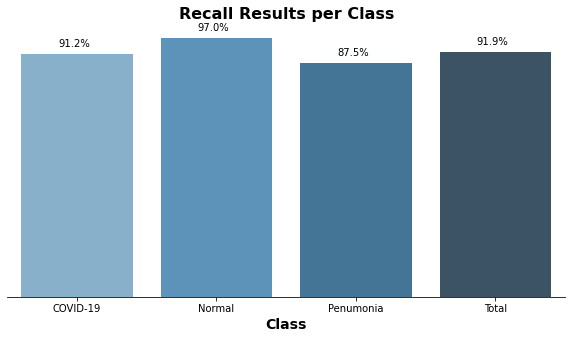

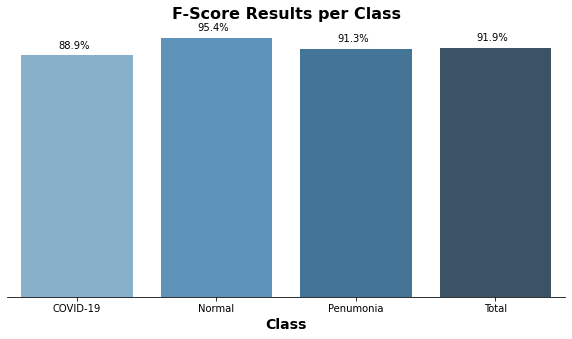

In [ ]:
print('ResNet50 without augmentation...')
generate_evaluation(test_generator.classes, y_pred_resnet50_unaug)